# imports and defs

In [63]:
import numpy as np
import pandas as pd
import bcsd_module as bb
import matplotlib.pyplot as plt
import utility_module_2_v_3 as uu
from datetime import datetime


In [64]:
def check_for_nans_infs_zeros(data_sts):
    print('Nans:',np.sum(np.isnan(data_sts)))
    print('Infs:' ,np.sum(np.isinf(data_sts)))
    print('Zeros:',np.sum((data_sts==0)))
    

In [65]:
## check dimensions and plot ts
def data_check(data_sts,lat,lon,Np= 12):
    check_for_nans_infs_zeros(data_sts)
    map_bounds=metadata['data_bounds'] #[50 , 50, 110, 0] #ltrb
    mp_spacing=10

    plt.figure(figsize = (12,2))

    plt.subplot(121)
    uu.map_plot_cyl(np.nanmean(data_sts[:,:,:],axis=0),lat,lon,map_bounds,mp_spacing=10)
    plt.title('Mean')

    plt.subplot(122)
    plt.plot(data_sts[:Np*5,int(lat.shape[0]/2),int(lon.shape[0]/2)])
    plt.plot(data_sts[-Np*5:,int(lat.shape[0]/2),int(lon.shape[0]/2)])


In [66]:
def create_mask(fo,lat_obs_cru,lon_obs_cru,buffer=0,plot=0):
  filename=gpd.read_file(fo)
  shp_geom = shape(filename.geometry[0])

  xxc, yyc = np.meshgrid(lon_obs_cru,lat_obs_cru)
  mask_shape=np.zeros(xxc.shape,dtype=bool)
  if plot==1:
    x,y = shp_geom.exterior.xy
    plt.plot(x,y)
  N1=xxc.shape[0]
  N2=xxc.shape[1]

  for lat_i in range(0,N1):
    for lon_i in range(0,N2):
      xi=xxc[lat_i,lon_i]
      yi=yyc[lat_i,lon_i]
      m1= (shp_geom.contains(Point(xi, yi)) or shp_geom.touches(Point(xi, yi)))
      mask_shape[lat_i,lon_i]=not m1

  return mask_shape

# Exp details

In [67]:
exp_names = ['US_P_BCSD',
'US_T_BCSD',]

SD_types = ['PREC','TEMP']

var_types = ['pre','tas']

df = pd.DataFrame(list(zip(exp_names, SD_types,var_types)),
               columns =['exp_names', 'SD_types', 'var_types'])
df

,exp_names,SD_types,var_types
0,US_P_BCSD,PREC,pre
1,US_T_BCSD,TEMP,tas


In [68]:
import geopandas as gpd
from shapely.geometry  import Point
from shapely.geometry import shape


In [81]:

itr=0
gcm_name= 'CanESM2'
exp_name = df['exp_names'][itr]
SD_type = df['SD_types'][itr]
var_type = df['var_types'][itr]

path_out = '/home/vikram/BCSD_data/' + exp_name  + '/'
lon_obs=metadata['lon_obs'] 
lat_obs=metadata['lat_obs']                                                       
lat_gcm=metadata['lat_gcm']
lon_gcm=metadata['lon_gcm']

metadata = np.load(path_out+var_type +'_metadata'+gcm_name + '.npy',allow_pickle=True).item()
pre_obs = np.load(path_out+var_type +'_obs'+ '.npy')
pre_gcm = np.load(path_out+var_type +'_gcm_'+gcm_name+ '.npy')

pre_obs_coarse = np.zeros((pre_obs.shape[0],pre_gcm.shape[1],pre_gcm.shape[2]))
for i in range(pre_obs.shape[0]):
    pre_obs_coarse[i,:,:] = uu.regrid(pre_obs[i,:,:], lat_obs,lon_obs  ,lat_gcm, lon_gcm)
    
    
    

fo='/home/vikram/BCSD_Shapefiles/us_rough.shp'
mask = create_mask(fo,lat_gcm ,lon_gcm-360,buffer=0,plot=0) 


# data_check(pre_obs_coarse*~mask, metadata['lat_gcm'], metadata['lon_gcm'])
# data_check(pre_gcm, metadata['lat_gcm'], metadata['lon_gcm'])

# plt.pcolor(mask)

# Bootstraping and BC

In [94]:
N=105
B=10
N1= pre_gcm.shape[1]
N2= pre_gcm.shape[2]
bias_corrected_uncen_output = np.zeros((N1,N2,B*B,N))

from tqdm import tqdm

data_bc = []
for n1 in tqdm(range(N1)):
    for n2 in range(N2):
        data_Jan  =  pre_gcm[:,n1,n2].reshape((12,-1),order = 'F' )[6,:]
        data_Jan_obs  =  pre_obs_coarse[:,n1,n2].reshape((12,-1),order = 'F' )[6,:] 
        
        x=data_Jan
        
        N=x.shape[0]
        data_Jan_samples= []
        for i in range(B):
            y = np.random.choice(x.tolist(), N, replace=True)
            data_Jan_samples.append(y)


        x=data_Jan_obs
        
        N=x.shape[0]
        data_Jan_samples_obs= []
        for i in range(B):
            y = np.random.choice(x.tolist(), N, replace=True)
            data_Jan_samples_obs.append(y)
            
            
        data_bc=[]
        for samp in samples:
            for samp_obs in samples_obs:
                a = bias_corr_historical_gamma_zeros(samp_obs,samp,)
                data_bc.append(a)
                
        bias_corrected_uncen_output[n1,n2,:,:]=np.array(data_bc)
        

100%|███████████████████████████████████████████| 11/11 [02:40<00:00, 14.61s/it]


In [98]:
_bias.shape

(105, 11, 22)

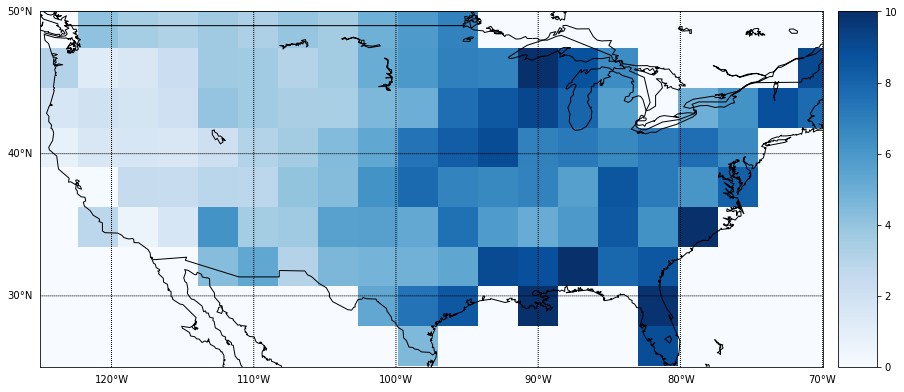

In [100]:
p_obs = pre_obs_coarse[:,:,:].reshape((12,-1,N1,N2),order = 'F' )[6,:]
p_gcm  =  pre_gcm[:,:,:].reshape((12,-1,N1,N2),order = 'F' )[6,:]

_bias =  p_gcm  -  p_obs
_std = np.moveaxis(np.std(bias_corrected_uncen_output,axis=2),2,0)
data_plot = (np.mean(np.abs(_bias/_std),axis=0))
map_plot_cyl(data_plot*~mask,lat_gcm,lon_gcm,metadata['data_bounds'],mp_spacing=10,vv=10)



In [88]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

def map_plot_cyl(data_lat_x_lon,lat_cen,lon_cen,map_bounds,mp_spacing=10,vv=10):
  

  lat_box=uu.cen_to_box(lat_cen)
  lon_box=uu.cen_to_box(lon_cen)

  fig=plt.figure(figsize=(15,7))
  map = Basemap(projection='cyl',resolution='l',
                llcrnrlon=map_bounds[0], 
                urcrnrlat=map_bounds[1],
                urcrnrlon=map_bounds[2], 
                llcrnrlat=map_bounds[3])


  xx, yy = np.meshgrid(lon_box,lat_box )
  #return  dimenion of lat * lon

  map.pcolor(xx, yy, data_lat_x_lon,cmap='Blues',vmax=vv,vmin=0)
  map.drawmeridians(np.arange(-180,180,mp_spacing),labels=[0,0,0,1], linewidth=1.0) #longitudes
  map.drawparallels(np.arange(-90,90,mp_spacing),labels=[1,0,0,0], linewidth=1.0) #latitudes

  map.drawcountries(linewidth=1)
  map.drawcoastlines(linewidth=1)

  map.colorbar()

  plt.show()

In [90]:
import scipy
from scipy.stats import gamma


def bias_corr_historical_gamma_zeros(data_grid_obs,data_grid_hist):
  var_data_obs = data_grid_obs
  var_data_hist = data_grid_hist

  var_data_obs[var_data_obs<0]=0
  var_data_hist[var_data_hist<0]=0
  
  var_data_obs[np.isnan(var_data_obs)]=0
  var_data_hist[np.isnan(var_data_hist)]=0

  bias_corr=np.zeros(var_data_hist.shape[0]);

  data=var_data_hist
  data_non_zeros=(data[data!=0])
  count_zeros=(data[data==0].shape[0])
  count_total=(data.shape[0])
  p_zeros=count_zeros/count_total
  fita,fitloc,fitscale = scipy.stats.gamma.fit(data_non_zeros,floc=0)

  cdf= p_zeros + (1 - p_zeros) * scipy.stats.gamma.cdf(var_data_hist, a=fita,loc=fitloc,scale=fitscale)

  data=var_data_obs
  data_non_zeros=(data[data!=0])
  count_zeros=(data[data==0].shape[0])
  count_total=(data.shape[0])
  p_zeros_imd=count_zeros/count_total
  ofita,ofitloc,ofitscale = scipy.stats.gamma.fit(data_non_zeros,floc=0)

  for iter in range(cdf.shape[0]):
    cdfi=cdf[iter]
    if cdfi<=p_zeros_imd:
      bias_corr[iter]=0
    else:
      z=(cdfi-p_zeros_imd)/(1-p_zeros_imd)
      bias_corr[iter]=scipy.stats.gamma.ppf(z, a=ofita,loc=ofitloc,scale=ofitscale)

  return bias_corr